In [1]:
%load_ext autoreload
%autoreload 2

In [231]:
from glob import glob
from pao_utils import parse_pao_file, append_samples
import pandas as pd
import numpy as np

import torch
import torch.utils.data
import se3cnn
import livelossplot as llp

import sys, os
import random
import numpy as np

from se3cnn.utils import torch_default_dtype
import se3cnn.point_utils as point_utils
from se3cnn.non_linearities import NormSoftplus
from se3cnn.convolution import SE3PointConvolution
from se3cnn.blocks.point_norm_block import PointNormBlock 
from se3cnn.point_kernel import gaussian_radial_function
from se3cnn.SO3 import torch_default_dtype

from functools import partial

torch.set_default_dtype(torch.float64)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [232]:
# Find and parse all .pao files.
# Each file corresponds to a molecular configuration, ie. a frame.
# Since the system contains multiple atoms, each .pao file contains multiple samples.
class PAODataset(object):
    def __init__(self, kind_name):
        self.kind_name = kind_name
        self.sample_coords = []
        self.sample_xblocks = []
        self.sample_iatoms = []

        #TODO split in training and test set
        for fn in glob("2H2O_MD/frame_*/2H2O_pao44-1_0.pao"):
            kinds, atom2kind, coords, xblocks = parse_pao_file(fn)
            for iatom, kind in enumerate(atom2kind):
                if kind != self.kind_name:
                    continue
                rel_coords = coords - coords[iatom,:] # relative coordinates
                self.sample_coords.append(rel_coords)
                self.sample_xblocks.append(xblocks[iatom])
                self.sample_iatoms.append(iatom)

        # assuming kinds and atom2kind are the same across whole training data
        kinds_enum = list(kinds.keys())
        self.kinds_onehot = np.zeros((len(kinds), len(atom2kind)))
        for iatom, kind in enumerate(atom2kind):
            idx = kinds_enum.index(kind)
            self.kinds_onehot[idx, iatom] = 1.0
        
    def __getitem__(self, idx):
        # roll central atom to the front
        iatom = self.sample_iatoms[idx]
        rolled_kinds = np.roll(self.kinds_onehot, shift=-iatom, axis=1)
        rolled_coords =  np.roll(self.sample_coords[idx], shift=-iatom, axis=0)  
        return rolled_kinds, rolled_coords, self.sample_xblocks[idx]

    def __len__(self):
        return len(self.sample_xblocks)

In [233]:
class PAONet(torch.nn.Module):
    def __init__(self, num_kinds, pao_basis_size, prim_basis_shells, num_radial=4, max_radius=2.5):
        super().__init__()
        self.num_kinds = num_kinds
        self.prim_basis_shells = prim_basis_shells
        self.pao_basis_size = pao_basis_size
        
        features = []
        features.append([num_kinds, 0, 0])  # L=0 for atom type as one-hot encoding
        features.append([8, 8, 8]) # hidden layer with filters L=0,1,2
        features.append([8, 8, 8]) # hidden layer with filters L=0,1,2
        features.append([ i * pao_basis_size for i in prim_basis_shells])

        nonlinearity = lambda x: torch.log(0.5 * torch.exp(x) + 0.5)
        sigma = max_radius / num_radial
        radii = torch.linspace(0, max_radius, steps=num_radial, dtype=torch.float64)
        radial_function = partial(gaussian_radial_function, sigma=2*sigma)
        radii_args = {'radii': radii, 'radial_function': radial_function}

        # Convolutions with Norm nonlinearity layers
        self.layers = torch.nn.ModuleList()
        
        # input layer
        self.layers.append(PointNormBlock(features[0], features[1], activation=nonlinearity, **radii_args))
        
        # hidden layer
        self.layers.append(PointNormBlock(features[1], features[2], activation=nonlinearity, **radii_args))
        
        # output layer
        Rs_repr = lambda features: [(m, l) for l, m in enumerate(features)]
        self.layers.append(SE3PointConvolution(Rs_repr(features[2]), Rs_repr(features[3]), **radii_args))
                        
        
    def forward(self, input, difference_mat, relative_mask=None):
        output = input
        for layer in self.layers:
            output = layer(output, difference_mat, relative_mask)
        return output

In [234]:
# assuming MOLOPT-DZVP as primary basis set
prim_basis_shells = {
    'H': [2, 1, 0], # two s-shells, one p-shell, no d-shells
    'O': [2, 2, 1], # two s-shells, two p-shells, one d-shell
}

net = PAONet(num_kinds=2, pao_basis_size=4, prim_basis_shells=prim_basis_shells['O'])
dataset = PAODataset("O")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=False)
for batch in dataloader:
    kind_onehot, coords, xblocks = batch    
    diff_M = se3cnn.point_utils.difference_matrix(coords)
    output = net(kind_onehot, diff_M)
    x = output[:,:,0]  # we rolled the central atom to the front
    print(x.shape)
    print(xblock.shape)
    #TODO: unpack output, assing via hungarian, pack xblock, compute loss
    
    # Compute loss
    loss = loss_fn(output, xblocks)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    break


torch.Size([5, 52])
(4, 13)


NameError: name 'loss_fn' is not defined

# Old Stuff

In [ ]:
def train(net, dataloader):
    liveloss = llp.PlotLosses()
    net.train()
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
    max_epochs = 100
    
    for epoch in range(max_epochs):
        logs = {}
        epoch_loss = 0
        for data in dataloader:
            coords, species, prim, mask, xblocks = data
            diff_M = se3cnn.point_utils.difference_matrix(coords)
            input = torch.cat([species, prim], dim=-2)
            output = net(input, diff_M)
            
            # Compute loss
            loss = loss_fn(output, xblocks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
        logs['loss'] = epoch_loss / len(dataloader)
        liveloss.update(logs)
        liveloss.draw()
    return net, liveloss

In [4]:
df = pd.DataFrame.from_dict(samples)

In [5]:
class PAODataset(object):
    def __init__(self, dataframe, max_prim=None, species_list=None, prim_by_species=None, num_pao=4):
        self.df = dataframe
        self.max_prim = max_prim if max_prim else [2, 2, 1]  # 2 s, 2 p and 2 d shell
        self.N = [len(coord) for coord in dataframe['coords']]
        self.N_max = np.max(self.N)
        self.species_list = species_list if species_list else ['H', 'O']
        self.prim_by_species = prim_by_species if prim_by_species else {'H' : [2, 1, 0], 'O' : [2, 2, 1]}
        self.num_pao = num_pao
                        
    def xblock_to_rect(self, prim, xblock):
        rect = []
        cur_block_index = 0
        for l,m in enumerate(self.max_prim):
            for i in range(m):
                if i <= prim[l] - 1:
                    rect.append(xblock[:, cur_block_index:cur_block_index+ (2 * l + 1)])
                    cur_block_index += 2 * l + 1
                else:
                    rect.append(np.zeros([self.num_pao, 2 * l + 1]))
        return rect  
    
    def prim_enc_to_onehot(self, prim):
        enc = []
        for l,m in enumerate(self.max_prim):
            for i in range(m):
                if i <= prim[l] - 1:
                    enc.append(np.ones(2 * l + 1))
                else:
                    enc.append(np.zeros(2 * l + 1))
        return enc
    
    def __getitem__(self, index):
        data = self.df.loc[index]
        species, coords, xblocks = data['atom2kind'], data['coords'], data['xblocks']
        N = self.N[index] 
        
        species_onehot = np.zeros([len(self.species_list), self.N_max])  # [species_channels, N]
        species_onehot[list(map(self.species_list.index, species)), range(N)] = 1.0
        
        prim_onehot = np.concatenate([
            np.concatenate(
                self.prim_enc_to_onehot(
                    self.prim_by_species[specie])).reshape(-1, 1) for specie in species
        ], axis=-1)  # [prim_channels, N]
        
        coords_rect = np.zeros([self.N_max, 3])
        coords_rect[:N] = coords
        
        # Not needed for this dataset because N always equals N_max
        # but we are showing this for completeness.
        mask = np.zeros(self.N_max)
        mask[:N] = 1.0
        
        xblocks_rect = []
        for i, (xblock, specie) in enumerate(zip(xblocks, species)):
            xblocks_rect.append(
                np.concatenate(
                    self.xblock_to_rect(self.prim_by_species[specie], xblock), axis=-1).reshape(-1, 1))
        xblocks_rect = np.concatenate(xblocks_rect, axis=-1)  # [output_channels, N]
            
        return (coords_rect, species_onehot, prim_onehot, mask, xblocks_rect)

    def __len__(self):
        return len(self.df)

In [6]:
class PAONet(torch.nn.Module):
    def __init__(self, num_radial=4, max_radius=2.5):
        super(PAONet, self).__init__()
        # atoms types 2 channels [H, O]
        features = [(4, 2, 1),  # 2 L=0 for atom type + 2 L=0, 2 L=1, 2 L=2 channels for primitive basis (use 1 and 0 to encode)
                    (8, 8, 8),  # hidden layers with filters L=0,1,2
                    (8, 8, 8),  # hidden layers with filters L=0,1,2
                    (4 * 2, 4 * 2, 4 * 1)]  # 4 pao functions * 2 max channels for prim basis that are linear combinations of different shells
        self.num_features = len(features)
        
        nonlinearity = lambda x: torch.log(0.5 * torch.exp(x) + 0.5)
        
        sigma = max_radius / num_radial

        kwargs = {
            'radii': torch.linspace(0, max_radius, steps=num_radial, dtype=torch.float64),
            'activation': nonlinearity,
            'radial_function': partial(gaussian_radial_function, sigma=2*sigma)
        }
        # Convolutions with Norm nonlinearity
        self.layers = torch.nn.ModuleList([PointNormBlock(features[i], features[i+1], **kwargs) for i in range(0, len(features) - 2)])
        # Final layer
        self.layers.extend([SE3PointConvolution(self.__Rs_repr(features[-2]), 
                                               self.__Rs_repr(features[-1]), 
                                               kwargs['radii'], 
                                               kwargs['radial_function'])])

    def forward(self, input, difference_mat, relative_mask=None):
        output = input # [B, N, C]
        for layer in self.layers:
            output = layer(output, difference_mat, relative_mask)
        return output

    def __Rs_repr(self, features):
        return [(m, l) for l, m in enumerate(features)]

    def __capsule_dims(self, Rs):
        return [2 * n + 1 for mul, n in Rs for i in range(mul)]

In [7]:
def train(net, dataloader):
    liveloss = llp.PlotLosses()
    net.train()
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=1e-2)
    max_epochs = 100
    
    for epoch in range(max_epochs):
        logs = {}
        epoch_loss = 0
        for data in dataloader:
            coords, species, prim, mask, xblocks = data
            diff_M = se3cnn.point_utils.difference_matrix(coords)
            input = torch.cat([species, prim], dim=-2)
            output = net(input, diff_M)
            
            # Compute loss
            loss = loss_fn(output, xblocks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
        logs['loss'] = epoch_loss / len(dataloader)
        liveloss.update(logs)
        liveloss.draw()
    return net, liveloss

In [8]:
dataset = PAODataset(df)
print(len(dataset))
batch_size = 5
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
net = PAONet()

81


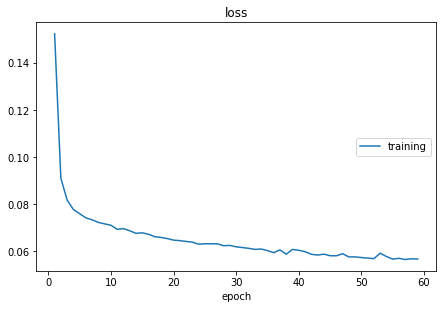

loss:
training   (min:    0.057, max:    0.152, cur:    0.057)


KeyboardInterrupt: 

In [9]:
train(net, dataloader)

In [54]:
torch.save(net.state_dict(), './first_try_pao_tfn.pth')

In [55]:
coords, species, prim, mask, xblocks = dataset.__getitem__(0)
channels = np.concatenate([species, prim], axis=0) # [S + P, N]
coords = torch.from_numpy(coords).unsqueeze(0)
channels = torch.from_numpy(channels).unsqueeze(0)  # [2, 6] + [13, 6] = [15, 6]
# mask = torch.from_numpy(mask)  # Don't need this for now
diff_M = se3cnn.point_utils.difference_matrix(coords)
output = net(channels, diff_M)  # [B, C, N]

In [56]:
np.max(np.abs(xblocks - output.detach().numpy()))

1.269823915231498

In [72]:
# xblocks.reshape(4, -1, 6)[:, 5, 0]

In [73]:
# output.reshape(4, -1, 6)[:, 5, 0]